In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = "SimHei" #解决中文乱码问题
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import model_selection

# 缺失值查看预处理

In [117]:
df_train = pd.read_csv(r'C:\Users\Lenovo\Downloads\data_format1\train_format1.csv')
df_test = pd.read_csv(r'C:\Users\Lenovo\Downloads\data_format1\test_format1.csv')
user_info = pd.read_csv(r'C:\Users\Lenovo\Downloads\data_format1\user_info_format1.csv')

In [118]:
user_log = pd.read_csv(r'C:\Users\Lenovo\Downloads\data_format1\user_log_format1.csv')

In [119]:
print(df_test.shape,df_train.shape)
print(user_info.shape,user_log.shape)

(261477, 3) (260864, 3)
(424170, 3) (54925330, 7)


根据本题数据描述中的对各字段值的介绍,我们发现用户画像中,age_range和gender中可能存在缺失值

In [120]:
user_info['gender'].fillna(2, inplace=True) #2和null都代表性别不确定
user_info['age_range'].fillna(-1, inplace=True)

再将2替换为-1,表示为未知,方便后续可视化

In [121]:
user_info['gender'].replace(2,-1,inplace=True)

Text(0.5, 1.0, '用户年龄分布')

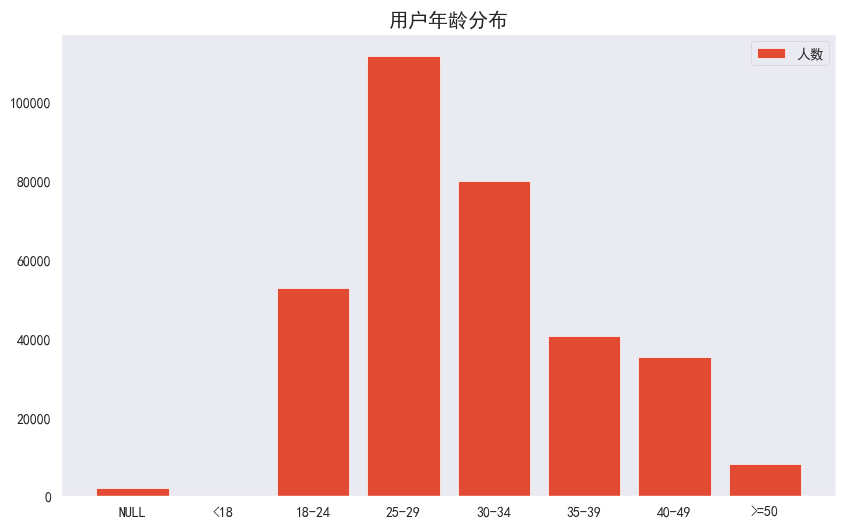

In [122]:
fig = plt.figure(figsize = (10, 6))
x = np.array(["NULL","<18","18-24","25-29","30-34","35-39","40-49",">=50"])
#<18岁为1；[18,24]为2； [25,29]为3； [30,34]为4；[35,39]为5；[40,49]为6； > = 50时为7和8
y = np.array([user_info[user_info['age_range'] == -1]['age_range'].count(),
             user_info[user_info['age_range'] == 1]['age_range'].count(),
             user_info[user_info['age_range'] == 2]['age_range'].count(),
             user_info[user_info['age_range'] == 3]['age_range'].count(),
             user_info[user_info['age_range'] == 4]['age_range'].count(),
             user_info[user_info['age_range'] == 5]['age_range'].count(),
             user_info[user_info['age_range'] == 6]['age_range'].count(),
             user_info[user_info['age_range'] == 7]['age_range'].count() + user_info[user_info['age_range'] == 8]['age_range'].count()])
plt.bar(x,y,label='人数')
plt.legend()
plt.title('用户年龄分布')

Text(0.5, 1.0, '用户年龄分布')

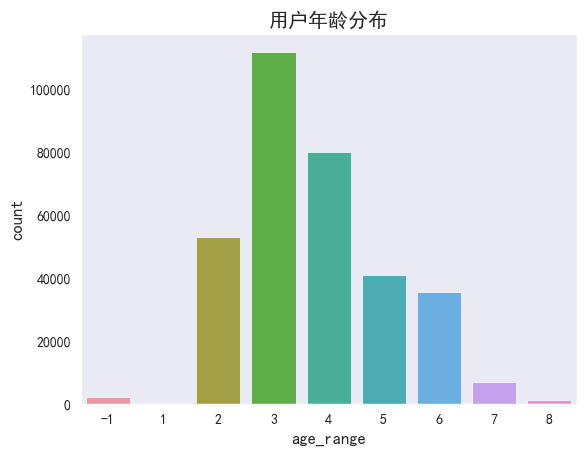

In [123]:
sns.countplot(x = 'age_range', order = [-1,1,2,3,4,5,6,7,8], data = user_info)
plt.title('用户年龄分布')

Text(0.5, 1.0, '用户性别分布')

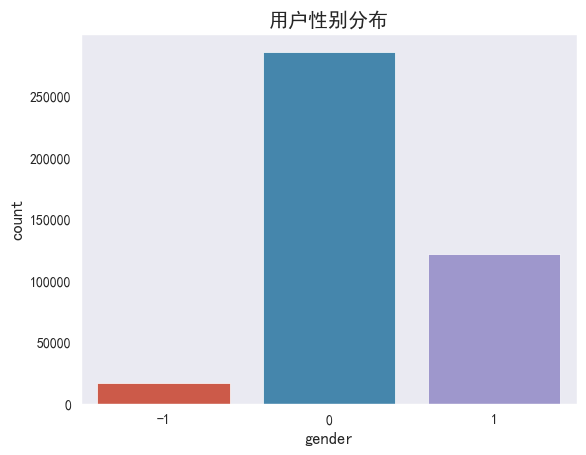

In [124]:
sns.countplot(x='gender',order = [-1,0,1],data = user_info)
plt.title('用户性别分布')

分析知:

性别缺省更多,年龄缺省较少

用户主要为女性群体和年轻群体

In [125]:
user_info['age_range'].replace(-1,np.nan,inplace=True)
user_info['gender'].replace(-1,np.nan,inplace=True)

Text(0.5, 1.0, '用户性别年龄分布')

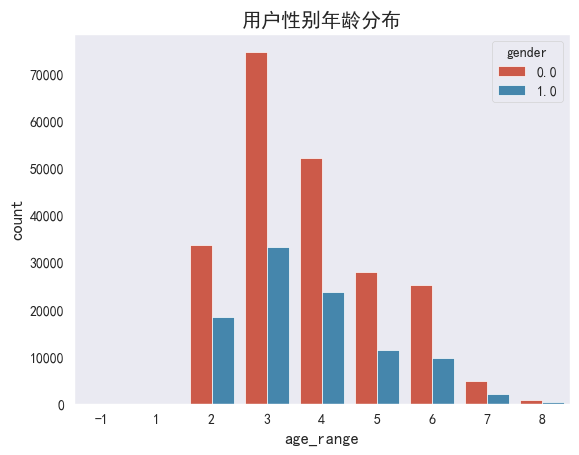

In [126]:
sns.countplot(x = 'age_range', order = [-1,1,2,3,4,5,6,7,8],hue= 'gender',data = user_info)
plt.title('用户性别年龄分布')

In [127]:
user_log.isnull().sum(axis=0)

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

# 初步可视化

+ user_log前面几行全是编码，购物者的唯一ID编码，商品的唯一编码，商品所属品类的唯一编码，商家的唯一ID编码，商品品牌的唯一编码
+ 后面是购买时间，与活动日志记录

我们发现:在brand_id(商品品牌)上存在大量缺失值

对用户行为中的购买时间(在本题所给出的数据描述中说time_tamp为购买时间,但个人认为其为时间戳,即无论是否购买,只要进入这个界面,就会被记录时间)和行为进行分析:

In [128]:
df_train.head(10)

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0
5,362112,2618,0
6,34944,2051,0
7,231552,3828,1
8,231552,2124,0
9,232320,1168,0


<Axes: >

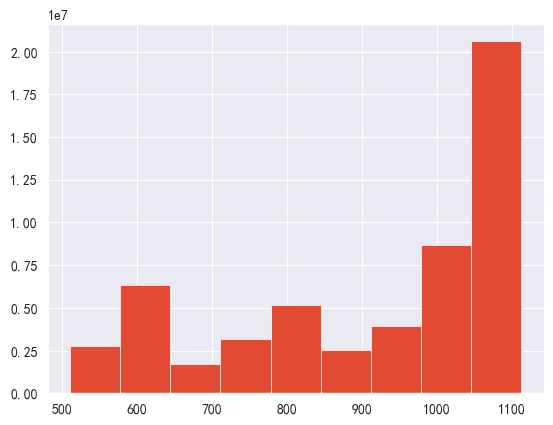

In [129]:
user_log['time_stamp'].hist(bins = 9)

+ 单以时间来看的话,在618和双十一的各种行为的量最多

<Axes: xlabel='action_type', ylabel='count'>

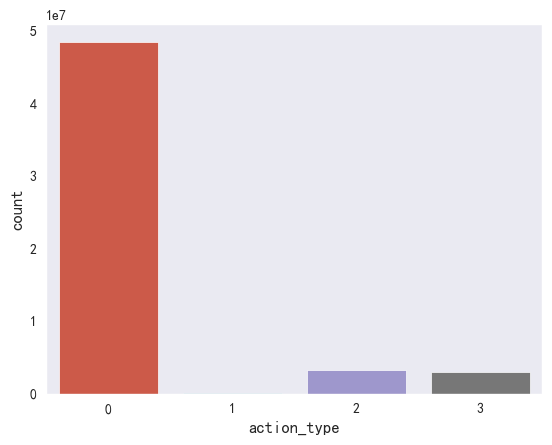

In [130]:
sns.countplot(x = 'action_type', order = [0,1,2,3],data = user_log)

+ 绝大多数都是单击，加入购物车的动作很少，比购买和收藏的动作还要少


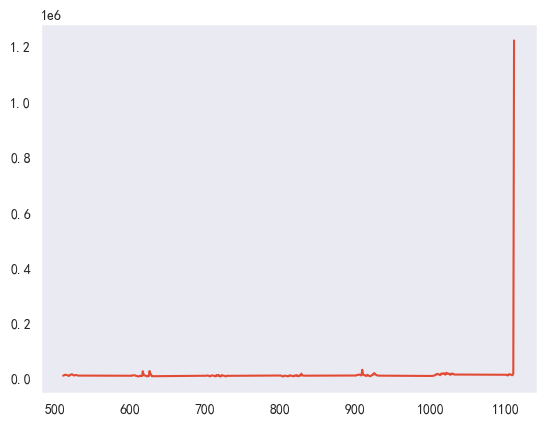

In [131]:
plt.plot(user_log[user_log['action_type']==2].groupby('time_stamp').count()['action_type'])
plt.show()

+ 我们发现购买行为主要集中在双十一

# 特征工程

## 想要建立的特征
需要根据user_id，和merchant_id（seller_id）,从用户画像表以及用户日志表中提取特征，填写到df_train这个数据框中，从而训练评估模型
需要建立的特征如下：
+ 用户的年龄(age_range)
+ 用户的性别(gender)
+ 某用户在该商家日志的总条数(total_logs)
+ 用户浏览的商品的数目，就是浏览了多少个商品(unique_item_ids)
+ 浏览的商品的种类的数目，就是浏览了多少种商品(categories)
+ 用户浏览的天数(browse_days)
+ 用户单击的次数(one_clicks)
+ 用户添加购物车的次数(shopping_carts)
+ 用户购买的次数(purchase_times)
+ 用户收藏的次数(favourite_times)

### age_range,gender特征添加

In [132]:
df_train = pd.merge(df_train,user_info,on="user_id",how="left")
df_train.head()

,user_id,merchant_id,label,age_range,gender
0,34176,3906,0,6.0,0.0
1,34176,121,0,6.0,0.0
2,34176,4356,1,6.0,0.0
3,34176,2217,0,6.0,0.0
4,230784,4818,0,0.0,0.0


### total_logs特征添加

In [133]:
total_logs_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"]]).count().reset_index()[["user_id","seller_id","item_id"]]

In [134]:

total_logs_temp.head()

,user_id,seller_id,item_id
0,1,471,1
1,1,739,1
2,1,925,4
3,1,1019,14
4,1,1156,1


In [135]:
total_logs_temp.rename(columns={"seller_id":"merchant_id","item_id":"total_logs"},inplace=True)
total_logs_temp.head()

,user_id,merchant_id,total_logs
0,1,471,1
1,1,739,1
2,1,925,4
3,1,1019,14
4,1,1156,1


In [136]:
df_train = pd.merge(df_train,total_logs_temp,on=["user_id","merchant_id"],how="left")
df_train.head()

,user_id,merchant_id,label,age_range,gender,total_logs
0,34176,3906,0,6.0,0.0,39
1,34176,121,0,6.0,0.0,14
2,34176,4356,1,6.0,0.0,18
3,34176,2217,0,6.0,0.0,2
4,230784,4818,0,0.0,0.0,8


### unique_item_ids特征添加

In [137]:
unique_item_ids_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["item_id"]]).count().reset_index()[["user_id","seller_id","item_id"]]

In [138]:
unique_item_ids_temp.head(10)

,user_id,seller_id,item_id
0,1,471,638653
1,1,739,556107
2,1,925,504149
3,1,1019,1110495
4,1,1156,896183
5,1,2245,181459
6,1,2245,452837
7,1,2245,543397
8,1,2245,779078
9,1,4026,112203


In [139]:
unique_item_ids_temp1 = unique_item_ids_temp.groupby([unique_item_ids_temp["user_id"],unique_item_ids_temp["seller_id"]]).count().reset_index()

In [140]:
unique_item_ids_temp1.head(10)

,user_id,seller_id,item_id
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,4
6,1,4026,1
7,1,4177,1
8,1,4335,1
9,2,420,15


In [141]:
unique_item_ids_temp1.rename(columns={"seller_id":"merchant_id","item_id":"unique_item_ids"},inplace=True)

In [142]:
unique_item_ids_temp1.head(10)

,user_id,merchant_id,unique_item_ids
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,4
6,1,4026,1
7,1,4177,1
8,1,4335,1
9,2,420,15


In [143]:
df_train = pd.merge(df_train,unique_item_ids_temp1,on=["user_id","merchant_id"],how="left")
df_train.head()

,user_id,merchant_id,label,age_range,gender,total_logs,unique_item_ids
0,34176,3906,0,6.0,0.0,39,20
1,34176,121,0,6.0,0.0,14,1
2,34176,4356,1,6.0,0.0,18,2
3,34176,2217,0,6.0,0.0,2,1
4,230784,4818,0,0.0,0.0,8,1


### categories特征构建

In [144]:
categories_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["cat_id"]]).count().reset_index()[["user_id","seller_id","cat_id"]]

In [145]:
categories_temp.head(20)

,user_id,seller_id,cat_id
0,1,471,389
1,1,739,1252
2,1,925,1023
3,1,1019,992
4,1,1156,1256
5,1,2245,276
6,1,4026,1252
7,1,4177,1252
8,1,4335,389
9,2,420,602


In [146]:
categories_temp1 = categories_temp.groupby([categories_temp["user_id"],categories_temp["seller_id"]]).count().reset_index()
categories_temp1.head(10)

,user_id,seller_id,cat_id
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,1
6,1,4026,1
7,1,4177,1
8,1,4335,1
9,2,420,2


In [147]:
categories_temp1.rename(columns={"seller_id":"merchant_id","cat_id":"categories"},inplace=True)
categories_temp1.head(10)

,user_id,merchant_id,categories
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,1
6,1,4026,1
7,1,4177,1
8,1,4335,1
9,2,420,2


In [148]:
df_train = pd.merge(df_train,categories_temp1,on=["user_id","merchant_id"],how="left")

In [149]:
df_train.head(10)

,user_id,merchant_id,label,age_range,gender,total_logs,unique_item_ids,categories
0,34176,3906,0,6.0,0.0,39,20,6
1,34176,121,0,6.0,0.0,14,1,1
2,34176,4356,1,6.0,0.0,18,2,1
3,34176,2217,0,6.0,0.0,2,1,1
4,230784,4818,0,0.0,0.0,8,1,1
5,362112,2618,0,4.0,1.0,1,1,1
6,34944,2051,0,5.0,0.0,3,2,1
7,231552,3828,1,5.0,0.0,83,48,15
8,231552,2124,0,5.0,0.0,7,4,1
9,232320,1168,0,4.0,1.0,4,1,1


### browse_days、one_clicks、shopping_carts、purchase_times、favourite_times特征构建

In [150]:
browse_days_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["time_stamp"]]).count().reset_index()[["user_id","seller_id","time_stamp"]]

In [151]:
browse_days_temp.head(10)

,user_id,seller_id,time_stamp
0,1,471,1111
1,1,739,1018
2,1,925,1011
3,1,1019,1111
4,1,1156,1111
5,1,2245,1009
6,1,4026,1018
7,1,4026,1021
8,1,4177,1018
9,1,4335,1111


In [152]:
browse_days_temp1 = browse_days_temp.groupby([browse_days_temp["user_id"],browse_days_temp["seller_id"]]).count().reset_index()
browse_days_temp1.head(10)

,user_id,seller_id,time_stamp
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,1
6,1,4026,2
7,1,4177,1
8,1,4335,1
9,2,420,1


In [153]:
browse_days_temp1.rename(columns={"seller_id":"merchant_id","time_stamp":"browse_days"},inplace=True)
browse_days_temp1.head(10)

,user_id,merchant_id,browse_days
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
5,1,2245,1
6,1,4026,2
7,1,4177,1
8,1,4335,1
9,2,420,1


In [154]:
df_train = pd.merge(df_train,browse_days_temp1,on=["user_id","merchant_id"],how="left")

In [155]:
df_train.head(10)

,user_id,merchant_id,label,age_range,gender,total_logs,unique_item_ids,categories,browse_days
0,34176,3906,0,6.0,0.0,39,20,6,9
1,34176,121,0,6.0,0.0,14,1,1,3
2,34176,4356,1,6.0,0.0,18,2,1,2
3,34176,2217,0,6.0,0.0,2,1,1,1
4,230784,4818,0,0.0,0.0,8,1,1,3
5,362112,2618,0,4.0,1.0,1,1,1,1
6,34944,2051,0,5.0,0.0,3,2,1,1
7,231552,3828,1,5.0,0.0,83,48,15,3
8,231552,2124,0,5.0,0.0,7,4,1,1
9,232320,1168,0,4.0,1.0,4,1,1,2


In [156]:
one_clicks_temp = user_log.groupby([user_log["user_id"],user_log["seller_id"],user_log["action_type"]]).count().reset_index()[["user_id","seller_id","action_type","item_id"]]

In [157]:
one_clicks_temp.head(10)

,user_id,seller_id,action_type,item_id
0,1,471,0,1
1,1,739,0,1
2,1,925,0,3
3,1,925,2,1
4,1,1019,0,10
5,1,1019,2,4
6,1,1156,0,1
7,1,2245,0,5
8,1,4026,0,4
9,1,4026,2,1


In [158]:
one_clicks_temp.rename(columns={"seller_id":"merchant_id","item_id":"times"},inplace=True)

In [159]:
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times
0,1,471,0,1
1,1,739,0,1
2,1,925,0,3
3,1,925,2,1
4,1,1019,0,10
5,1,1019,2,4
6,1,1156,0,1
7,1,2245,0,5
8,1,4026,0,4
9,1,4026,2,1


In [160]:
one_clicks_temp["one_clicks"] = one_clicks_temp["action_type"] == 0

In [161]:
one_clicks_temp["one_clicks"] = one_clicks_temp["one_clicks"] * one_clicks_temp["times"]

In [162]:
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times,one_clicks
0,1,471,0,1,1
1,1,739,0,1,1
2,1,925,0,3,3
3,1,925,2,1,0
4,1,1019,0,10,10
5,1,1019,2,4,0
6,1,1156,0,1,1
7,1,2245,0,5,5
8,1,4026,0,4,4
9,1,4026,2,1,0


In [163]:
one_clicks_temp["shopping_carts"] = one_clicks_temp["action_type"] == 1

In [164]:
one_clicks_temp["shopping_carts"] = one_clicks_temp["shopping_carts"] * one_clicks_temp["times"]

In [165]:
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times,one_clicks,shopping_carts
0,1,471,0,1,1,0
1,1,739,0,1,1,0
2,1,925,0,3,3,0
3,1,925,2,1,0,0
4,1,1019,0,10,10,0
5,1,1019,2,4,0,0
6,1,1156,0,1,1,0
7,1,2245,0,5,5,0
8,1,4026,0,4,4,0
9,1,4026,2,1,0,0


In [166]:
one_clicks_temp["purchase_times"] = one_clicks_temp["action_type"] == 2

In [167]:
one_clicks_temp["purchase_times"] = one_clicks_temp["purchase_times"] * one_clicks_temp["times"]

In [168]:
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times,one_clicks,shopping_carts,purchase_times
0,1,471,0,1,1,0,0
1,1,739,0,1,1,0,0
2,1,925,0,3,3,0,0
3,1,925,2,1,0,0,1
4,1,1019,0,10,10,0,0
5,1,1019,2,4,0,0,4
6,1,1156,0,1,1,0,0
7,1,2245,0,5,5,0,0
8,1,4026,0,4,4,0,0
9,1,4026,2,1,0,0,1


In [169]:
one_clicks_temp["favourite_times"] = one_clicks_temp["action_type"] == 3

In [170]:
one_clicks_temp["favourite_times"] = one_clicks_temp["favourite_times"] * one_clicks_temp["times"]

In [171]:
one_clicks_temp.head(10)

,user_id,merchant_id,action_type,times,one_clicks,shopping_carts,purchase_times,favourite_times
0,1,471,0,1,1,0,0,0
1,1,739,0,1,1,0,0,0
2,1,925,0,3,3,0,0,0
3,1,925,2,1,0,0,1,0
4,1,1019,0,10,10,0,0,0
5,1,1019,2,4,0,0,4,0
6,1,1156,0,1,1,0,0,0
7,1,2245,0,5,5,0,0,0
8,1,4026,0,4,4,0,0,0
9,1,4026,2,1,0,0,1,0


In [172]:
four_features = one_clicks_temp.groupby([one_clicks_temp["user_id"],one_clicks_temp["merchant_id"]]).sum().reset_index()

In [173]:
four_features.head(10)

,user_id,merchant_id,action_type,times,one_clicks,shopping_carts,purchase_times,favourite_times
0,1,471,0,1,1,0,0,0
1,1,739,0,1,1,0,0,0
2,1,925,2,4,3,0,1,0
3,1,1019,2,14,10,0,4,0
4,1,1156,0,1,1,0,0,0
5,1,2245,0,5,5,0,0,0
6,1,4026,2,5,4,0,1,0
7,1,4177,0,1,1,0,0,0
8,1,4335,0,1,1,0,0,0
9,2,420,2,26,23,0,3,0


In [174]:
four_features = four_features.drop(["action_type","times"], axis=1)

In [175]:
df_train = pd.merge(df_train,four_features,on=["user_id","merchant_id"],how="left")

In [176]:
df_train.head(10)

,user_id,merchant_id,label,age_range,gender,total_logs,unique_item_ids,categories,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times
0,34176,3906,0,6.0,0.0,39,20,6,9,36,0,1,2
1,34176,121,0,6.0,0.0,14,1,1,3,13,0,1,0
2,34176,4356,1,6.0,0.0,18,2,1,2,12,0,6,0
3,34176,2217,0,6.0,0.0,2,1,1,1,1,0,1,0
4,230784,4818,0,0.0,0.0,8,1,1,3,7,0,1,0
5,362112,2618,0,4.0,1.0,1,1,1,1,0,0,1,0
6,34944,2051,0,5.0,0.0,3,2,1,1,2,0,1,0
7,231552,3828,1,5.0,0.0,83,48,15,3,78,0,5,0
8,231552,2124,0,5.0,0.0,7,4,1,1,6,0,1,0
9,232320,1168,0,4.0,1.0,4,1,1,2,2,0,1,1


## 建立好的特征的缺失值处理

In [177]:
df_train = df_train.fillna(method='ffill')
# 缺失值向前填充

# 模型构建与调参

### 数据处理

In [178]:
Y = df_train['label']
X = df_train.drop(['user_id','merchant_id','label'],axis = 1)
X.head(10)

,age_range,gender,total_logs,unique_item_ids,categories,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times
0,6.0,0.0,39,20,6,9,36,0,1,2
1,6.0,0.0,14,1,1,3,13,0,1,0
2,6.0,0.0,18,2,1,2,12,0,6,0
3,6.0,0.0,2,1,1,1,1,0,1,0
4,0.0,0.0,8,1,1,3,7,0,1,0
5,4.0,1.0,1,1,1,1,0,0,1,0
6,5.0,0.0,3,2,1,1,2,0,1,0
7,5.0,0.0,83,48,15,3,78,0,5,0
8,5.0,0.0,7,4,1,1,6,0,1,0
9,4.0,1.0,4,1,1,2,2,0,1,1


In [179]:
Y.head(10)

0    0
1    0
2    1
3    0
4    0
5    0
6    0
7    1
8    0
9    0
Name: label, dtype: int64

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25,random_state = 10)

### 决策树

In [181]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=4,random_state=0) 
tree.fit(X_train, y_train)
Predict_proba = tree.predict_proba(X_test)
print(Predict_proba[:])
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

[[0.89760368 0.10239632]
 [0.95949188 0.04050812]
 [0.95949188 0.04050812]
 ...
 [0.91089364 0.08910636]
 [0.95949188 0.04050812]
 [0.93376113 0.06623887]]
Accuracy on training set: 0.939
Accuracy on test set: 0.938


### 随机森林

In [182]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=10, random_state=2) 
forest.fit(X_train, y_train)
Predict_proba = forest.predict_proba(X_test)
print(Predict_proba[:])
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

[[1.         0.        ]
 [0.95795342 0.04204658]
 [0.95381343 0.04618657]
 ...
 [0.8        0.2       ]
 [0.95216854 0.04783146]
 [0.9        0.1       ]]
Accuracy on training set: 0.959
Accuracy on test set: 0.932


### 梯度提升回归树

In [183]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state=0) 
gbrt.fit(X_train, y_train)
Predict_proba = gbrt.predict_proba(X_test)
print(Predict_proba[:])
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

[[0.86844502 0.13155498]
 [0.9591827  0.0408173 ]
 [0.95470227 0.04529773]
 ...
 [0.91863465 0.08136535]
 [0.96262757 0.03737243]
 [0.91516868 0.08483132]]
Accuracy on training set: 0.939
Accuracy on test set: 0.938


# 实践预测

## 特征构建

In [184]:
df_test = pd.merge(df_test,user_info,on="user_id",how="left")

In [185]:
df_test = pd.merge(df_test,total_logs_temp,on=["user_id","merchant_id"],how="left")

In [186]:
df_test = pd.merge(df_test,unique_item_ids_temp1,on=["user_id","merchant_id"],how="left")

In [187]:
df_test = pd.merge(df_test,categories_temp1,on=["user_id","merchant_id"],how="left")

In [188]:
df_test = pd.merge(df_test,browse_days_temp1,on=["user_id","merchant_id"],how="left")

In [189]:
df_test = pd.merge(df_test,four_features,on=["user_id","merchant_id"],how="left")

In [190]:
df_test = df_test.fillna(method='bfill')
# 缺失值向后填充

In [191]:
df_test.head(10)

,user_id,merchant_id,prob,age_range,gender,total_logs,unique_item_ids,categories,browse_days,one_clicks,shopping_carts,purchase_times,favourite_times
0,163968,4605,NaN,0.0,0.0,2,1,1,1,1,0,1,0
1,360576,1581,NaN,2.0,0.0,10,9,4,1,5,0,5,0
2,98688,1964,NaN,6.0,0.0,6,1,1,1,5,0,1,0
3,98688,3645,NaN,6.0,0.0,11,1,1,1,10,0,1,0
4,295296,3361,NaN,2.0,1.0,50,8,4,5,47,0,1,2
5,33408,98,NaN,2.0,0.0,11,2,1,4,9,0,1,1
6,230016,1742,NaN,5.0,1.0,13,6,1,1,11,0,2,0
7,164736,598,NaN,3.0,1.0,2,1,1,1,1,0,1,0
8,164736,1963,NaN,3.0,1.0,3,2,1,1,2,0,1,0
9,164736,2634,NaN,3.0,1.0,7,4,3,1,6,0,1,0


## 模型预测

In [192]:
X1 = df_test.drop(['user_id','merchant_id','prob'],axis = 1)

### 决策树

In [193]:
Predict_proba = tree.predict_proba(X1)

In [194]:
df_test["Tree_prob"] = Predict_proba[:,1]

### 随机森林

In [195]:
Predict_proba = forest.predict_proba(X1)

In [196]:
df_test["Forest_prob"] = Predict_proba[:,1]

### 梯度提升回归树

In [197]:
Predict_proba = gbrt.predict_proba(X1)

In [198]:
df_test["Gbrt_prob"] = Predict_proba[:,1]

## 结果保存

In [199]:
choose = ["user_id","merchant_id","Gbrt_prob"]
res = df_test[choose]
res.rename(columns={"Gbrt_prob":"prob"},inplace=True)
print(res.head(10))
res.to_csv(path_or_buf = r"C:\Users\Lenovo\Downloads\data_format1\prediction.csv",index = False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18208\2872529199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res.rename(columns={"Gbrt_prob":"prob"},inplace=True)


   user_id  merchant_id      prob
0   163968         4605  0.039774
1   360576         1581  0.113643
2    98688         1964  0.045139
3    98688         3645  0.045139
4   295296         3361  0.077108
5    33408           98  0.045457
6   230016         1742  0.073900
7   164736          598  0.037372
8   164736         1963  0.042870
9   164736         2634  0.054369
